#Implementation for a neural network that can:


1.   take 3 inputs :
> an image from the MNIST dataset (say 5), a random number between 0 and 9, (say 7) & the current MNIST-label.


2.  and gives two outputs(as in example below) :
> for example: the "number" that was represented by the MNIST image (predict 5), and the "sum" of this number with the random number and the input image to the network (predict 5 + 7 = 12)








#### import satements for all required Python packages.

In [1]:
from __future__ import print_function

''''from  __future__ import' statements can be used on *top-of* one's Python 
2.x code to enable new language features, that are not available in the older 
versions of Python. Esp. 'from __future__ import print_function' is a 
statement that one can use at the *top-of* the Python 2.x code to enable the 
print *function* from Python 3.x. In Python 2.x, the print *statement* is 
used to print to the standard output stream, whereas in Python 3.x, the print 
*function* is used. By using from __future__ import print_function, one can 
use the print *function* in the Python 2.x code, which can make it easier to 
port the code to Python 3.x in the future. '''
import torch

'''imports the torch module. This module provides functions for working with 
PyTorch, a popular open-source machine learning library for Python that is 
based on the Torch library used primarily for natural language processing and 
computer vision tasks. PyTorch provides a high-level interface for working 
with neural networks and allows users to perform complex operations on 
tensors with strong acceleration on many-core GPUs. '''
import torch.nn as nn

'''imports the torch.nn module (into the namespace nn by convention) from the 
torch package. This module provides a set of classes and functions that are 
commonly used to build and train neural networks in PyTorch. It contains 
classes for defining various types of layers in a neural network, as well as 
methods for forward propagation, backward propagation, and optimization. '''
import torch.nn.functional as F

'''imports torch.nn.functional module into the namespace F by convention. 
This module contains all the functions in the torch.nn library (whereas other 
parts of the library contain classes) and a wide range of loss and activation 
functions, one also finds here, some convenient functions for creating neural 
nets, such as pooling functions. '''
import torch.optim as optim

'''imports the torch.optim module from the torch package into the namespace 
optim. This module provides a set of classes and functions for 
*optimizing-the-parameters* of a neural network in PyTorch. It contains 
implementations of various optimization algorithms, such as stochastic 
gradient descent (SGD), Adam, and RMSprop. By importing the optim module and 
using the classes and functions it provides, one can *train-a-neural-network* 
in PyTorch by specifying the optimization algorithm and the network's 
parameters to optimize. '''

'''imports the datasets & transforms  modules from the torchvision package. 
The torchvision package is a popular library for working with image data in 
PyTorch. It contains a collection of functions and classes for loading, 
transforming, and analyzing image data. The *datasets module* provides 
classes for loading and organizing image data into datasets that can be 
easily used to train a neural network. The transforms module provides a set 
of common image transformations that can be applied to images in a dataset. 
These transformations include operations such as resizing, cropping, 
and normalizing the images. '''
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchsummary import summary
'''module is a progress bar library that is used to provide a visual indication
of the progress of a long-running operation in a Python script.'''
from tqdm import tqdm

####Some globals defined here

In [2]:
batch_size = 128
epochs = 10
train_losses_in1 = []
train_losses_in2 = []
test_losses_in1 = []
test_losses_in2 = []
train_acc_in1 = []
train_acc_in2 = []
test_acc_in1 = []
test_acc_in2 = []
class_names = ["zero",  # index 0
               "one",  # index 1
               "two",  # index 2
               "three",  # index 3
               "four",  # index 4
               "five",  # index 5
               "six",  # index 6
               "seven",  # index 7
               "eight",  # index 8
               "nine"]  # index 9

### Custom dataset-class required here:
The constructor takes in following params:
>train_data (dict): 
A dictionary having two columns(/keys):-1. "mnist_input" {ndarry: (60000,28,28)} (representing the numpy-format MNIST training data, and named as "train_mnist_set_array", this is kept in numpy format, so as to be able to use the "transform" callable, provided as argument ("transform_in1") for this custom-dataset class, so as to convert to the required Tensor format, with all required posible list of transforms applied to it.
 &  2. "rand_num_input"{Tensor:(60000,10)} (representing the Random-number input from the [0,9] in one-hot-encoded form, named as "train_rand_num_set_array_one_hot", this does not require any transform, hence though there is a 2nd transform-interface provided for the 2nd input of this overall neural network (provided as argument "transform_in2"), butinterface not used.

> test_data (dict): A dictionary having two columns(/keys):-1. "mnist_input" {ndarry: (10000,28,28)} (representing the numpy-format MNIST test data, and named as "test_mnist_set_array", this is kept in numpy format, so as to be able to use the "transform" callable, provided as argument ("transform_in1") for this custom-dataset class, so as to convert to the required Tensor format, with all required posible list of transforms applied to it.
 &  2. "rand_num_input"{Tensor:(60000,10)} (representing the Random-number input from the [0,9] in one-hot-encoded form, named as "test_rand_num_set_array_one_hot", this does not require any transform, hence though, there is a 2nd transform-interface provided for the 2nd input of this overall neural network (provided as argument "transform_in2"), but interface not used.

>train_target (dict): A dictionary having two columns(/keys):-1. "mnist_output"{Tensor: (60000,)} (representing the Tensor-format MNIST train-labels/targets, and named as "train_mnist_set_array_targets".
 &  2. "sum_of_mnist_rand_num_output"{Tensor:(60000,19)} (representing the sum output expected to be from the [0,18] in one-hot-encoded form, named as "train_sum_of_mnist_rand_num_set_array_one_hot".

>test_target (dict): A dictionary having two columns(/keys):-1. "mnist_output"{Tensor: (10000,)} (representing the Tensor-format MNIST test-labels/targets, and named as "test_mnist_set_array_targets".
 &  2. "sum_of_mnist_rand_num_output"{Tensor:(60000,19)} (representing the sum output expected to be from the [0,18] in one-hot-encoded form, named as "test_sum_of_mnist_rand_num_set_array_one_hot".

>train: True if the dataset will be used in train mode(by default kept True)

>test: True if the dataset will be used in test mode(by default kept False).Assert if both train & test flag true simultaneously.)

>transform_in1: a "callable" data-transform inteface provided for the part# 1 of the neural network (made up of the CNN layers & catering to the mnist image input) By default kept as None.

>transform_in2: a "callable" data-transform inteface provided for the part# 2 of the neural network (made up of the FC-layers & catering to the random number input) By default kept as None.





            

In [3]:
class MNIST_RAND_IN_Dataset(Dataset):
    """Dataset For MNIST train/test & Rand-Num-In & Summation target """

    def __init__(self, train_data, test_data, train_target, test_target,
                 train=True, test=False, transform_in1=None,
                 transform_in2=None):
        """
        Args:
            train_data (dict): contains tensor-format train-data for both:
            "mnist_input"{Tensor: (60000,28,28)} & "rand_num_input"{Tensor:
            (60000,10)}
            test_data (dict): contains tensor-format test-data for both:
            "mnist_input"{Tensor: (10000,28,28)} & "rand_num_input"{Tensor:
            (10000,10)}
            train_target (dict): contains tensor-format train-targets for both:
            "mnist_output"{Tensor: (60000,10)} & "sum_of_mnist_rand_num_output"
            {Tensor: (60000,19)}
            test_target (dict): contains tensor-format test-targets for both:
            "mnist_output"{Tensor: (10000,10)} & "sum_of_mnist_rand_num_output"
            {Tensor: (10000,19)}
            train: True if the dataset will be used in train mode
            test: True if the dataset will be used in test mode (assert if both
                  train & test flag true simultaneously.
            transform_in1: a "callable" data-transform inteface for mnist image
            transform_in2: a "callable" data-transform inteface for rand-num in
        """
        #Below class-variables receive the data from
        #various dict described above (and implmented under 
        #a function named: "source_data()")

        #the numpy-format MNIST training data
        self.x_train_mnist = train_data["mnist_input"]
        #the Random-number input from the [0,9] in 
        #one-hot-encoded form
        self.x_train_rand_num = train_data["rand_num_input"]
        #the numpy-format MNIST test data
        self.x_test_mnist = test_data["mnist_input"]
        #the Random-number input from the [0,9] in 
        #one-hot-encoded form
        self.x_test_rand_num = test_data["rand_num_input"]
        #the Tensor-format MNIST train-labels/targets
        self.y_train_mnist = train_target["mnist_output"]
        #the sum output expected to be from the [0,18] 
        #in one-hot-encoded form
        self.y_train_sum_of_mnist_rand_num = \
            train_target["sum_of_mnist_rand_num_output"]
        #the Tensor-format MNIST train-labels/targets
        self.y_test_mnist = test_target["mnist_output"]
        #the sum output expected to be from the [0,18] 
        #in one-hot-encoded form
        self.y_test_sum_of_mnist_rand_num = \
            test_target["sum_of_mnist_rand_num_output"]
        #train cfg-flag
        self.train = train
        #test cfg-flag
        self.test = test
        #assert if the user tried creating test & train
        #dataset with both train & test flags same at 
        #the same time.
        assert self.train != self.test
        #Transform interface for Input1(mnist image)
        #of the NN (being used for ToTensor & Normalize)
        self.transform_in1 = transform_in1
        #Transform interface for Input2(mrand-num)
        #of the NN (not used curently)
        self.transform_in2 = transform_in2

    def __len__(self):
        if self.train:
            assert len(self.x_train_mnist) == len(self.x_train_rand_num)
            return len(self.x_train_mnist)
        else:
            assert len(self.x_test_mnist) == len(self.x_test_rand_num)
            return len(self.x_test_mnist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.train:
            #create an input tuple for 2 inputs
            (mnist_image, rand_num_in) = (self.x_train_mnist[idx],
                                          self.x_train_rand_num[idx])
            #create an target tuple for 2 outputs
            (mnist_target, sum_of_mnist_rand_num_target) = \
                (self.y_train_mnist[idx],
                 self.y_train_sum_of_mnist_rand_num[idx])
            # print("Before transform, values:")
            # plt.imshow(mnist_image)
            # plt.show()
        else:
            (mnist_image, rand_num_in) = (self.x_test_mnist[idx],
                                          self.x_test_rand_num[idx])
            (mnist_target, sum_of_mnist_rand_num_target) = \
                (self.y_test_mnist[idx], self.y_test_sum_of_mnist_rand_num[idx])
        if self.transform_in1:
            # if torch.is_tensor(mnist_image):
            #     mnist_image = mnist_image.numpy()
            mnist_image = self.transform_in1(mnist_image)
            # print("self.transform_in1: ", self.transform_in1)
            # print("After transform, values:")
            # plt.imshow(mnist_image.numpy().squeeze())
            # plt.show()
        if self.transform_in2:
            # if torch.is_tensor(mnist_image):
            #     mnist_image = mnist_image.numpy()
            rand_num_in = self.transform_in2(rand_num_in)

        return (mnist_image, rand_num_in), (mnist_target,
                                            sum_of_mnist_rand_num_target)




##### Helper function to provide one-hot-encoded tensor of given width from an input tensor(this one is used by another function, named "source_data" which in turn is used to create various required dicts for the custom-dataset class)
The method takes in 2 args & returns one as follows:
>input_tensor : an input tensor to be encoded

>width : width of the one-hot-encoded result.

>one_hot: one-hot-encoded tensor output

In [4]:
def one_hot_custom(input_tensor, width, device=None):
    # Convert the data type of the input tensor to long
    input_tensor = input_tensor.long()
    # Create an identity matrix with the desired one-hot encoded width
    one_hot_tensor = torch.eye(width, dtype=torch.float)
    if device is not None:
      one_hot_tensor = one_hot_tensor.to(device)

    # Use the input tensor as an index tensor to index into the one-hot tensor
    one_hot = one_hot_tensor[input_tensor]
    return one_hot

### Function to provide various data/target dicts and feed into the  custom-dataset class descibed earlier:
The method takes in no args but returns following:
>train_data (dict): same as described in earlier comments under class-dataset description

>test_data (dict): same as described in earlier comments under class-dataset description

>train_target: same as described in earlier comments under class-dataset description

>test_target: same as described in earlier comments under class-dataset description

In [5]:
def source_data():
    # 1. convert the Torchvision MNIST train and test datasets into NumPy
    # arrays & take some already tensor format data it provides:
    train_mnist_set = datasets.MNIST('./data', train=True, download=True)
    test_mnist_set = datasets.MNIST('./data', train=False, download=True)
    train_mnist_set_array = train_mnist_set.data.numpy()  # Later transforms
    # require them to be numpy array
    train_mnist_set_array_targets = train_mnist_set.targets  # a Tensor format
    # already.
    test_mnist_set_array = test_mnist_set.data.numpy()  # Later transforms
    # require them to be numpy array
    test_mnist_set_array_targets = test_mnist_set.targets  # a Tensor format
    # already.
    mnist_train_set_length = len(train_mnist_set)
    mnist_test_set_length = len(test_mnist_set)

    # 2.  Create a tensor of mnist_train_set_length (60000) random
    # numbers from [0-9] in a shape (60000,) & mnist_test_set_length (10000)
    # random numbers from [0-9] in a shape (10000,)

    # First set the random seed for reproducibility
    np.random.seed(0)
    # Generate mnist_train_set_length (60000) number of, random integers
    # between 0 and 9.Following creates tensor with 60000 elements
    # filled with random integers from the range [0, 10).The upper
    # bound is not included, so the generated integers will range from 0 to 9
    train_rand_num_set_array = torch.randint(low=0, high=10,
                                             size=(mnist_train_set_length,),
                                             dtype=torch.int)
    # similar for test here:
    test_rand_num_set_array = torch.randint(low=0, high=10,
                                            size=(mnist_test_set_length,),
                                            dtype=torch.int)

    # 3.    Given two tensors (train_mnist_set_array_targets &
    # train_rand_num_set_array) of shape(60000,) with random numbers,
    # following creates a tensor with same shape i.e.( 60000,)the sum of
    # the elements.The resulting array will have the same shape as the input
    # arrays, and will contain the sums of the corresponding elements.
    train_sum_of_mnist_rand_num_set_array = \
        torch.add(train_mnist_set_array_targets,
                  train_rand_num_set_array)

    # Following will generate two tensors with of shape(10000,)
    #and calculate the sum of the elements from the same rows of the
    # arrays. The resulting tensor will have the same shape as the input
    # arrays, and will contain the sums of the corresponding elements.
    test_sum_of_mnist_rand_num_set_array = \
        torch.add(test_mnist_set_array_targets,
                  test_rand_num_set_array)

    # 4.Now encode train & test tensors for inputs & targets for rand_in
    # and Sum_out  only.
    train_rand_num_set_array_one_hot = one_hot_custom(train_rand_num_set_array,
                                                      width=10)
    test_rand_num_set_array_one_hot = one_hot_custom(test_rand_num_set_array,
                                                     width=10)
    train_sum_of_mnist_rand_num_set_array_one_hot = \
        one_hot_custom(train_sum_of_mnist_rand_num_set_array,
                       width=19)
    test_sum_of_mnist_rand_num_set_array_one_hot = \
        one_hot_custom(test_sum_of_mnist_rand_num_set_array,
                       width=19)

    train_data = {
        # The provision to transform the  "mnist_input" part below, into the
        # required [0,1) distribution Tensor has already been made under the
        # custom Dataset class (with a class constructor-argument named:
        # "transform_in1", where *_in1 represents the transformation required
        # for the input to the part # 1 of this neural network.Similar other
        # class constructor-argument named: "transform_in2" has also been
        # provided to potentially cater to the input to the part #2 of this
        # neural network.But currently kept as None.
        "mnist_input": train_mnist_set_array,
        # Below part of the data input: "rand_num_input" don't undergo
        # transformation through the custom-Dataset inbuilt transform.
        #Its already kept in form of a one-hot-encoded tensor.
        "rand_num_input": train_rand_num_set_array_one_hot
    }
    train_target = {
        # the Tensor-format MNIST train-labels/targets
        "mnist_output": train_mnist_set_array_targets,
        
        # the sum output expected to be from the [0,18] in 
        #one-hot-encoded form
        "sum_of_mnist_rand_num_output":
            train_sum_of_mnist_rand_num_set_array_one_hot
    }

    test_data = {
        # The provision to transform the  "mnist_input" part below, into the
        # required [0,1) distribution Tensor has already been made under the
        # custom Dataset class (with a class constructor-argument named:
        # "transform_in1", where *_in1 represents the transformation required
        # for the input to the part # 1 of this neural network.Similar other
        # class constructor-argument named: "transform_in2" has also been
        # provided to potentially cater to the input to the part #2 of this
        # neural network.But currently kept as None.
        "mnist_input": test_mnist_set_array,
        # Below part of the data input: "rand_num_input" don't undergo
        # transformation through the custom-Dataset inbuilt transform.
        #Its already kept in form of a one-hot-encoded tensor.
        "rand_num_input": test_rand_num_set_array_one_hot
    }

    test_target = {
        # the Tensor-format MNIST train-labels/targets
        "mnist_output": test_mnist_set_array_targets,
        # the sum output expected to be from the [0,18] in 
        #one-hot-encoded form
        "sum_of_mnist_rand_num_output":
            test_sum_of_mnist_rand_num_set_array_one_hot
    }
    return train_data, test_data, train_target, test_target

#####helper function, to display some of the mnist image data along with rand-in, & sum out, obtained from the above dataset (using dataloader given much below in this code-page.)
The method takes in 2 args & returns nothing as follows:
>data_ldr : an input dataloader (a usage much below in this page)

>num_times : display the sample how many times(default 5)



In [6]:
def display_few_batch_samples(data_ldr, num_times=5):
    for i in range(num_times):
        dataiter = next(iter(data_ldr))
        (mnist_image, rand_num_in), (mnist_target,
                                     sum_of_mnist_rand_num_target) = dataiter

        print("mnist_image.shape: ", mnist_image.shape)
        print("rand_num_in.shape: ", rand_num_in.shape)
        print("mnist_target.shape: ", mnist_target.shape)
        print("sum_of_mnist_rand_num_target.shape: ",
              sum_of_mnist_rand_num_target.shape)
        img_number = np.random.randint(mnist_image.shape[0])
        print("rand_num_in[{}]=  {}".format(img_number,
                                            rand_num_in[img_number].argmax()))
        print("mnist_target[{}]=  {}".format(img_number,
                                             mnist_target[img_number]))
        print("sum_of_mnist_rand_num_target[{}]=  {}".format(
            img_number,
            sum_of_mnist_rand_num_target[img_number].argmax()))
        plt.figure().suptitle('{} '.format(
            class_names[mnist_target[img_number]]),
            fontsize=20)
        _ = plt.imshow(mnist_image.squeeze().numpy()[img_number, ::],
                       interpolation='nearest')
        plt.show()

#####For the neural network(NN), the mnsit image goes thru the given layering below, which, with an input image size of 28x28x1.This forms the first "part" of the NN.Actually here, this layering is leveraged off the earlier session assignment, but now merged to cater to the  additional rand-num input and sum_of_mnist_rand_rum output too.The additional set of inputs and outputs are taken thru a layering of fully connected layers.

>Please note that for the FC-part a provision is made to potentially go for 2 inputs as well (though currently only one input rand_num goes thru), In case in future experiment an additional input is required that can also be concatenated along (in all one-hot-enoded formats)

The Net class construct hence provides these args:
>num_inputs_for_fc_part=1 (provision for concatenated 2 outputs, currently only one)

>sum_out_features=19 (width 19 one hot encoded sum_out related FC has these out features)

>num_hidden_fc_features=100 (a hidden in between FC layer requires these, by default 100)


Input Channels/Image  |  Conv2d/Transform      | Output Channels | RF
---------------------|--------------|----------------------|------
**28x28x1**              | **(3x3x1)x32**   |      **28x28x32**(padding=1) |      **3x3**
             |          `ReLU`  | 
**28x28x32**             | **(3x3x32)x64**  |      **28x28x64**(padding=1) |      **5x5**  
             |          `ReLU`  | 
**28x28x64**             | *MP(2x2)*  |      **14x14x64** |      **10x10**  
**14x14x64**             | **(3x3x64)x128** | **14x14x128**(padding=1)  |  **12x12**
             |          `ReLU`  | 
**14x14x128**            | **(3x3x128)x256**| **14x14x256** (padding=1)|   **14x14** 
             |          `ReLU`  |
**14x14x256**            | *MP(2x2)*  |      **7x7x256** |      **28x28**
**7x7x256**              | **(3x3x256)x512**  |**5x5x512** (no padding)|      **30x30**
             |          `ReLU`  |   
**5x5x512**              | **(3x3x512)x1024**  | **3x3x1024** (no padding)  |  **32x32** 
             |          `ReLU`  | 
**3x3x1024**             | **(3x3x1024)x10**  | **1x1x10** (no padding)  |  **34x34**

In [7]:
class Net(nn.Module):
    """
    defines a new class called Net, that inherits from the nn.Module class.
    This class is used to define a *custom neural network* in PyTorch. With
    the  creation a new Net class, one can define the structure of the
    network by adding layers and defining the forward propagation method.
    """

    def __init__(self, num_inputs_for_fc_part=1, sum_out_features=19,
                 num_hidden_fc_features=100):
        super(Net, self).__init__()
        # Logical-grouping of the "Part 1" of Neural Network, which (in parallel
        # with an independent 2nd part of Neural Network), handles the MNIST
        # Image label and predicts an MNIST Label out).This part is
        # "structurally" (i.e. storable parameters/weights wise) composed of
        # convolutional layers (with required functional associations to various
        # "functional"  max-pool, activation etc. layers provided under upcoming
        # "forward propagation" method named as "forward".
        # input:28x28x1, kernel_size=3x3,  output:28x28x32, RF:3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32,
                               kernel_size=(3, 3), padding=1, bias=False)
        # input:28x28x32, kernel_size=3x3, output:28x28x64, RF:5x5
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=(3, 3), padding=1, bias=False)
        # MaxPool2d(2, 2):  # input:28x28x64, output:14x14x64, RF:10x10
        # input:14x14x64,  kernel_size=3x3,  output:14x14x128, RF:12x12
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=(3, 3), padding=1, bias=False)
        # input:14x14x128, kernel_size=3x3,  output:14x14x256, RF:14x14
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256,
                               kernel_size=(3, 3), padding=1, bias=False)
        # MaxPool2d(2, 2)  # input:14x14x256, output:7x7x256, RF:28x28
        # input:7x7x256, kernel_size=3x3,  output:5x5x512(no padding), RF:30x30
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512,
                               kernel_size=(3, 3), bias=False)
        # input:5x5x512, kernel_size=3x3, output:3x3x1024 (no padding), RF:32x32
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024,
                               kernel_size=(3, 3), bias=False)
        # input:3x3x1024,  kernel_size=3x3, output:1x1x10(no padding), RF:34x34
        self.mnist_out_conv = nn.Conv2d(in_channels=1024, out_channels=10,
                                        kernel_size=(3, 3), bias=False)

        # Logical-grouping of the "Part 2" of Neural Network, which (in
        # parallel with an "independent" (with implementation as shown in the
        # forward method below) 1st part of Neural Network, handles
        # the Random Number input (and also optionally with the current MNIST
        # label as a separate future experiment) and predicts Sum of this 
        # random-num with the MNIST label out).This part is "structurally"
        # (i.e. storable parameters/weights wise) being composed of 
        # fully-connected layers here (with other required functional 
        # associations etc provided under (the same as earlier) upcoming 
        # "forward propagation" method named "forward".
        self.num_inputs_for_fc_part = num_inputs_for_fc_part  # 1 or 2
        self.num_hidden_fc_features = num_hidden_fc_features  # 100
        self.sum_out_features = sum_out_features  # 19
        # in_features=20 is [10 from MNIST-label, 10 from rand_num in]
        assert self.num_inputs_for_fc_part in (1, 2), \
            "num_inputs_for_fc_part must be 1 or 2"
        self.fc1 = nn.Linear(in_features=10 * self.num_inputs_for_fc_part,
                             out_features=self.num_hidden_fc_features,
                             bias=False)  #
        # self.num_hidden_fc_features (default value 100 here) is the
        # capacity boost (an intermediate hidden-layer expansion) to this 2nd
        # part of this Neural network, which is made up of all fully connected
        # layers and which caters to the random num input (with/without the
        # current MNIST label) and generates a 19 wide one-hot-encoded
        # sum-output
        self.fc2 = nn.Linear(in_features=self.num_hidden_fc_features,
                             out_features=self.num_hidden_fc_features,
                             bias=False)
        self.sum_out_fc = nn.Linear(in_features=self.num_hidden_fc_features,
                                    out_features=self.sum_out_features,
                                    bias=False)

    def forward(self, t1, t2, t3=None):  #
        # t3 or mnist_label_in (for a future experiment, is by default None.
        #(and by default we cater to just 2 inputs: 1. t1: mnist-image and 
        # 2.t2:rand-number (10-wide one-hot-encoded number)) But as our 
        # expectation with such 2 "random" inputs with no correlation (along 
        # with an equally un-correlated Output sum-label) is that they won't 
        # let this neural network learn(for the 2nd part), hence as a future
        # experiment a provision is made to input a 3rd input: t3 too, in form 
        # of: "current-mnist-label" too.With this experiment of using an
        # additional mnist-label input along with the random number input is
        # that there are chances for neural network to learn now?? (with 
        # pre-stored randon num input values, for each mnist data along with
        # the calculated pre-stored sum of mnist labels and random numbers)

        ##### START OF--Functional-grouping of the "Part 1" of Neural Network
        # Input Layer for Part #1
        mnist_image_conv = t1

        # 1st Conv2d layer for Part #1:
        mnist_image_conv = self.conv1(mnist_image_conv)
        mnist_image_conv = F.relu(mnist_image_conv)

        # 2nd Conv2d layer for Part #1::
        mnist_image_conv = self.conv2(mnist_image_conv)
        mnist_image_conv = F.relu(mnist_image_conv)
        mnist_image_conv = F.max_pool2d(mnist_image_conv, kernel_size=(2, 2),
                                        stride=2)

        # 3rd Conv2d layer for Part #1::
        mnist_image_conv = self.conv3(mnist_image_conv)
        mnist_image_conv = F.relu(mnist_image_conv)

        # 4th Conv2d layer for Part #1::
        mnist_image_conv = self.conv4(mnist_image_conv)
        mnist_image_conv = F.relu(mnist_image_conv)
        mnist_image_conv = F.max_pool2d(mnist_image_conv, kernel_size=(2, 2),
                                        stride=2)

        # 5th Conv2d layer for Part #1::
        mnist_image_conv = self.conv5(mnist_image_conv)
        mnist_image_conv = F.relu(mnist_image_conv)

        # 6th Conv2d layer for Part #1::
        mnist_image_conv = self.conv6(mnist_image_conv)
        mnist_image_conv = F.relu(mnist_image_conv)

        # Final Conv-layer for part1 SHOULD be WITHOUT ReLU!
        mnist_image_conv = self.mnist_out_conv(
            mnist_image_conv)  # Final conv2d layer for part 1
        mnist_image_conv = mnist_image_conv.view(-1, 10)
        #Below log_softmax is being removed as F.cross_entropy will be used 
        #for the two independent set of inputs, and cross-entropy combines
        #softmax+nll-loss together.
        # mnist_image = F.log_softmax(mnist_image, dim=1)
        #####  END OF--Functional-grouping of the "Part 1" of Neural Network

        #####  START OF--Functional-grouping of the "Part 2" of Neural Network
        # First we decide here to send either the single one-hot-encoded randum
        # num input, or the concat of the one-hot-encoded randum num input with
        # current one-hot-encoded mnist label
        if t3 is not None:  # i.e. If we want to experiment with a 3rd
            # input t3 (representing the current MNIST-label: mnist_label)
            # Concatenate t2 (representing rand_num input) and t3 (representing
            # mnist_label input) along the second dimension & get that as the
            # input to the part #2 of this neural-network.
            t_nn_part2_fc = torch.cat((t2, t3), dim=1)
        else:
            # If mnist_label input is not provided, just get rand_num input
            # as the input to the part #2 of this neural-network.
            t_nn_part2_fc = t2

            # Input Layer for Part #2
        sum_output_fc = t_nn_part2_fc
        sum_output_fc = sum_output_fc.reshape(-1,
                                              self.num_inputs_for_fc_part * 10)

        # 1st fully-connected layer fc1 for Part #2:
        sum_output_fc = self.fc1(sum_output_fc)
        sum_output_fc = F.relu(sum_output_fc)
        sum_output_fc = self.fc2(sum_output_fc)
        sum_output_fc = F.relu(sum_output_fc)

        # 2nd fully-connected layer self.sum_out (last of this Part2 of this
        # NN--no ReLU)
        sum_output_fc = self.sum_out_fc(sum_output_fc)
        #Below log_softmax is being removed as F.cross_entropy will be used 
        #for the two independent set of inputs, and cross-entropy combines
        # sum_output = F.log_softmax(sum_output, dim=1)

        #####  END OF--Functional-grouping of the "Part 2" of Neural Network

        return mnist_image_conv, sum_output_fc


In [8]:
def get_correct_pred_count(preds, labels):
    """
    Args:
        preds (Tensor-2D): contains a 2-rank tensor of predictions
        labels (Tensor-2D): contains a 2-rank tensor of ground-truth labels
    """
    return preds.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()


def train_model(model, device, train_loader, optimizer_in1, optimizer_in2):
    """
    A train function for a neural network is a function that is used to train
    the network on a dataset. The function typically performs the following
    steps:
    1. Iterate over the training dataset in mini-batches using a loop.
    2. For each mini-batch, pass the data through the network to make
    predictions.
    3. Calculate the loss (error) of the predictions using a loss
    function.
    4. Use the optimizer to update the network's weights and biases
    based on the loss.
    5. Repeat the above steps for a specified number of epochs (iterations over
    the entire dataset).
    """
    model.train()
    '''model.train() sets the model to train mode. This is typically done 
    because some models have different behaviors in training and evaluation 
    modes. For example, the model may use dropout regularization when in 
    training mode but not in evaluation mode. '''
    pbar = tqdm(train_loader)
    correct_in1 = 0
    correct_in2 = 0
    processed_in1 = 0
    processed_in2 = 0
    '''above creates a progress bar using the tqdm library. The progress bar 
    will be used to show the progress of the training loop. '''
    for batch_idx, (batch_in1, batch_in2) in enumerate(pbar):
        '''starts a for loop that will iterate over the training dataset in 
        mini-batches. The enumerate function is used to add a counter to the 
        loop so that the current mini-batch index can be tracked. The 
        progress bar pbar is passed as the argument to the enumerate function 
        so that it can be updated on each iteration of the loop. '''
        (mnist_image_batch, rand_num_in_batch) = batch_in1
        (mnist_target_batch, sum_of_mnist_rand_num_target_batch) = \
            batch_in2
        data_in1, target_in1 = \
            mnist_image_batch.to(device), mnist_target_batch.to(device)
        data_in2, target_in2 = \
            rand_num_in_batch.to(device), \
            sum_of_mnist_rand_num_target_batch.to(device)
        '''above moves the mini-batch data and targets to the specified 
        device (e.g. CPU or GPU). '''
        optimizer_in1.zero_grad()
        optimizer_in2.zero_grad()
        '''In PyTorch, for every mini-batch during the training phase, 
        we typically want to explicitly set the gradients to zero before 
        starting to do backpropagation (i.e., updating the Weights) because 
        PyTorch accumulates the gradients on subsequent backward 
        passes.i.e.the default action is set to accumulate (i.e. sum) the 
        gradients on every loss.backward() call. Because of this, when one 
        starts training loop, should zero out the gradients so that the 
        parameter update correctly. Otherwise, the gradient would be a 
        combination of the old gradient, which has already been used to 
        update model parameters, and the newly-computed gradient. '''
        output_in1, output_in2 = model(data_in1, #mnist-image
                                       data_in2, #rand-num
                                       # & current mnist-label
                                       one_hot_custom(target_in1, width=10,
                                                      device=device))
        '''above passes the mini-batch data through the model to make 
        predictions. '''
        loss_in1 = F.cross_entropy(output_in1, target_in1)
        train_losses_in1.append(loss_in1.item())
        loss_in2 = F.cross_entropy(output_in2, target_in2)
        train_losses_in2.append(loss_in2.item())

        loss_in1.backward()
        loss_in2.backward()
        '''above calculates the gradients of the loss with respect to the 
        model's parameters. This is done using backpropagation. '''
        optimizer_in1.step()
        optimizer_in2.step()
        '''above updates the model's parameters using the gradients and the 
        optimizer's update rule. '''
        pred_in1 = output_in1.argmax(dim=1,
                                     keepdim=True)  # get the index of the max
        # log-probability
        pred_in2 = output_in2.argmax(dim=1,
                                     keepdim=True)  # get the index of the max
        # log-probability
        correct_in1 += pred_in1.eq(target_in1.view_as(pred_in1)).sum().item()
        correct_in2 += get_correct_pred_count(pred_in2, target_in2)
        processed_in1 += len(data_in1)
        processed_in2 += len(data_in2)
        '''updates the progress bar with the current loss and batch index. 
        This allows the user to see the progress of the training loop and the 
        current loss. '''
        pbar.set_description(desc=f'loss_in1={loss_in1.item()}  '
                                  f'loss_in2={loss_in2.item()} '
                                  f'Accuracy_in1= '
                                  f'{correct_in1}/{len(train_loader.dataset)} '
                                  f'({100 * correct_in1 / processed_in1:0.2f})%'
                                  f'Accuracy_in2= '
                                  f'{correct_in2}/{len(train_loader.dataset)} '
                                  f'({100 * correct_in2 / processed_in2:0.2f})%'
                                  f'batch_id={batch_idx}')


def test_model(model, device, test_loader):
    model.eval()
    '''model.eval() sets the model to test mode. This is typically done 
    because some models have different behaviors in training and evaluation 
    modes. '''
    test_loss_in1 = 0
    test_loss_in2 = 0
    correct_in1 = 0
    correct_in2 = 0
    with torch.no_grad():
        '''When testing a model, don't want to compute gradients since we are 
        not training the model. Disabling gradients can save memory and can 
        make the computations faster. This is why it is common to see a 
        torch.no_grad() context manager used inside a test function. It 
        prevents the computations inside the block from tracking gradients, 
        which can save memory and improve performance. '''
        for (batch_in1, batch_in2) in test_loader:
            (mnist_image_batch, rand_num_in_batch) = batch_in1
            (mnist_target_batch, sum_of_mnist_rand_num_target_batch) = \
                batch_in2
            data_in1, target_in1 = \
                mnist_image_batch.to(device), mnist_target_batch.to(device)
            data_in2, target_in2 = \
                rand_num_in_batch.to(device), \
                sum_of_mnist_rand_num_target_batch.to(device)
            output_in1, output_in2 = model(data_in1, #mnist image
                                           data_in2, #rand-num
                                           # & current-mnist-label
                                           one_hot_custom(target_in1, width=10,
                                                      device=device))
            test_loss_in1 += \
                F.cross_entropy(output_in1, target_in1,
                                reduction='sum').item()  # sum
            test_loss_in2 += \
                F.cross_entropy(output_in2, target_in2,
                                reduction='sum').item()  # sum
            # up batch loss
            pred_in1 = output_in1.argmax(dim=1, keepdim=True)  # get the
            # index of the max log-probability
            pred_in2 = output_in1.argmax(dim=1, keepdim=True)  # get the
            # index of the max log-probability
            correct_in1 += pred_in1.eq(
                target_in1.view_as(pred_in1)).sum().item()
            correct_in2 += get_correct_pred_count(pred_in2, target_in2)

            '''Here, pred and target are tensors that represent the model's 
            predictions and the true targets, respectively. The .eq() method 
            is used to compare the two tensors element-wise, and returns a 
            tensor of the same shape with binary values (0 or 1) indicating 
            whether the corresponding elements in pred and target are equal. 
            The .sum() method is used to sum all the elements in the tensor, 
            and the .item() method is used to convert the resulting scalar 
            tensor to a Python scalar. So the overall effect of this code is 
            to compute the number of correct predictions made by the model 
            and add it to the correct variable. '''

    '''below test_loss is a variable that represents the average loss across 
    all the test examples, and test_loader.dataset is a dataset object that 
    contains all the test examples. The len() function is used to compute the 
    number of examples in the dataset, and this value is used to divide the 
    test_loss by the number of examples. The result is the average loss per 
    example, which is a more useful metric for evaluating the model's 
    performance. '''
    test_loss_in1 /= len(test_loader.dataset)
    test_loss_in2 /= len(test_loader.dataset)

    print(
        '\nTest set: Average loss_in1: {:.4f}, '
        'Accuracy_in1: {}/{} ({:.0f}%)\n'.format(test_loss_in1,
                                                 correct_in1,
                                                 len(test_loader.dataset),
                                                 100. * correct_in1 /
                                                 len(test_loader.dataset)))

    print(
        '\nTest set: Average loss_in2: {:.4f}, '
        'Accuracy_in2: {}/{} ({:.0f}%)\n'.format(test_loss_in2,
                                                 correct_in2,
                                                 len(test_loader.dataset),
                                                 100. * correct_in2 /
                                                 len(test_loader.dataset)))

CUDA Available? True
device:  cuda

	***Display some of the data thus generated:

mnist_image.shape:  torch.Size([128, 1, 28, 28])
rand_num_in.shape:  torch.Size([128, 10])
mnist_target.shape:  torch.Size([128])
sum_of_mnist_rand_num_target.shape:  torch.Size([128, 19])
rand_num_in[44]=  0
mnist_target[44]=  6
sum_of_mnist_rand_num_target[44]=  6


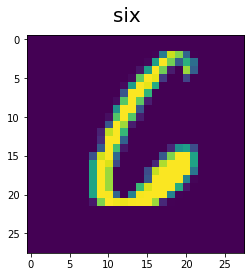

mnist_image.shape:  torch.Size([128, 1, 28, 28])
rand_num_in.shape:  torch.Size([128, 10])
mnist_target.shape:  torch.Size([128])
sum_of_mnist_rand_num_target.shape:  torch.Size([128, 19])
rand_num_in[47]=  2
mnist_target[47]=  4
sum_of_mnist_rand_num_target[47]=  6


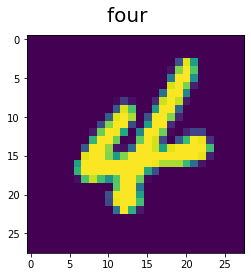

mnist_image.shape:  torch.Size([128, 1, 28, 28])
rand_num_in.shape:  torch.Size([128, 10])
mnist_target.shape:  torch.Size([128])
sum_of_mnist_rand_num_target.shape:  torch.Size([128, 19])
rand_num_in[117]=  7
mnist_target[117]=  9
sum_of_mnist_rand_num_target[117]=  16


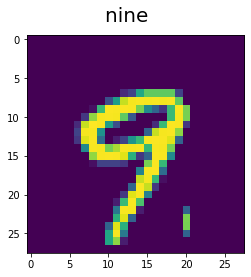

mnist_image.shape:  torch.Size([128, 1, 28, 28])
rand_num_in.shape:  torch.Size([128, 10])
mnist_target.shape:  torch.Size([128])
sum_of_mnist_rand_num_target.shape:  torch.Size([128, 19])
rand_num_in[64]=  2
mnist_target[64]=  3
sum_of_mnist_rand_num_target[64]=  5


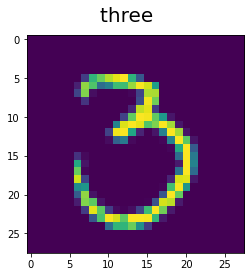

mnist_image.shape:  torch.Size([128, 1, 28, 28])
rand_num_in.shape:  torch.Size([128, 10])
mnist_target.shape:  torch.Size([128])
sum_of_mnist_rand_num_target.shape:  torch.Size([128, 19])
rand_num_in[67]=  7
mnist_target[67]=  4
sum_of_mnist_rand_num_target[67]=  11


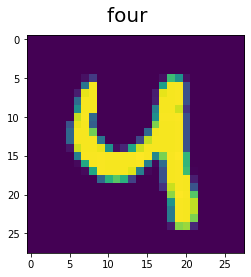

In [9]:
SEED = 1
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if cuda else "cpu")
print("device: ", device)

# For reproducibility
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
# Create a consolidated Dataset:
train_data, test_data, train_target, test_target = source_data()
train_data_set = MNIST_RAND_IN_Dataset(train_data, test_data, train_target,
                                       test_target,
                                       train=True, test=False,
                                       # Required transforms for In1(for
                                       # part 1 of the NN)
                                       transform_in1=transforms.Compose(
                                           [  # for input 1 mnist image only
                                               transforms.ToTensor(),
                                               transforms.Normalize(
                                                   (0.1307,),
                                                   (0.3081,))
                                           ])
                                       # Not Required transforms for In2(for
                                       # part 2 of the NN)
                                       )
test_data_set = MNIST_RAND_IN_Dataset(train_data, test_data, train_target,
                                      test_target,
                                      train=False, test=True,
                                      # Required transforms for In1(for
                                      # part 1 of the NN)
                                      transform_in1=transforms.Compose(
                                          [  # for input 1 mnist image only
                                              transforms.ToTensor(),
                                              transforms.Normalize(
                                                  (0.1307,),
                                                  (0.3081,))
                                          ])
                                      # Not Required transforms for In2(for
                                      # part 2 of the NN)
                                      )
train_dataloader_args = dict(shuffle=True, batch_size=batch_size,
                             num_workers=2,
                             pin_memory=True) if cuda else \
    dict(shuffle=False, batch_size=batch_size)
test_dataloader_args = dict(shuffle=True, batch_size=batch_size,
                            num_workers=2, pin_memory=True) if cuda else \
    dict(shuffle=True, batch_size=batch_size)
# train dataloader
train_loader = torch.utils.data.DataLoader(train_data_set,
                                           **train_dataloader_args)
# test dataloader
test_loader = torch.utils.data.DataLoader(test_data_set,
                                          **test_dataloader_args)
print("\n\t***Display some of the data thus generated:\n")
display_few_batch_samples(train_loader)

###Finally train and test the neural network (there were many in-between debug steps, like starting out with single sampl, going on to batch sample & testing backpropagation and gradient updates & loss and accuracy checks, that were performed at my own end, and are not displayed here)Here The final test and train function are used to display the final set of results.At this point, the progress bars and the messages show the improvements in the results for the MNSIT predictions but a dismal 1% for the sum_out prediction (which was kind of expected as the input and output spaces are from a random distribution and hence network is not supposed to learn for the 2nd part)

In [10]:
model = Net(2).to(device) # The "2nd Part"(the fully-connected(FC)-part)
                          # has 2 inputs rand-in + curent-mnist-label.
'''above creates an instance of a PyTorch neural network model, and then 
moves the model to the specified device (CPU or GPU). In this case, 
Net() creates an instance of a neural network class called Net, and the to(
device) method moves the model to the device specified by the device 
variable. This line of code is typically used in conjunction with the device 
variable being set to a torch.device object that represents the device (CPU 
or GPU) on which the model should be allocated '''

'''below optim.SGD() function is used to create the optimizer objectss, and it 
takes several arguments. The first argument is the model.parameters(), 
which tells the optimizer which parameters of the model to update during 
training. The lr argument specifies the learning rate, which determines the 
size of the step that the optimizer takes in the direction of the gradient. 
The momentum argument specifies the momentum, which is a technique that can 
improve the performance of the optimizer and can help the model converge 
faster. In this case, the optimizer is configured to use a learning rate of 
0.01 and a momentum of 0.9. '''
optimizer_in1 = optim.SGD(params=[param for name, param in
                                  model.named_parameters() if
                                  'conv' in name], lr=0.01, momentum=0.9)
optimizer_in2 = optim.SGD(params=[param for name, param in
                                  model.named_parameters() if
                                  'fc' in name], lr=0.01, momentum=0.9)

'''This following code trains a model for one epoch and then tests the model 
on the test set.  '''
for epoch in range(0, 10):
    print("EPOCH:", epoch + 1)
    train_model(model, device, train_loader, optimizer_in1, optimizer_in2)
    test_model(model, device, test_loader)

EPOCH: 1


loss_in1=0.06289205700159073  loss_in2=2.1441330909729004 Accuracy_in1= 51535/60000 (85.89)%Accuracy_in2= 593/60000 (0.99)%batch_id=468: 100%|██████████| 469/469 [00:23<00:00, 20.31it/s]



Test set: Average loss_in1: 0.0620, Accuracy_in1: 9792/10000 (98%)


Test set: Average loss_in2: 2.1526, Accuracy_in2: 104/10000 (1%)

EPOCH: 2


loss_in1=0.03607624024152756  loss_in2=0.7177146673202515 Accuracy_in1= 58951/60000 (98.25)%Accuracy_in2= 593/60000 (0.99)%batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.41it/s]



Test set: Average loss_in1: 0.0342, Accuracy_in1: 9890/10000 (99%)


Test set: Average loss_in2: 0.7073, Accuracy_in2: 104/10000 (1%)

EPOCH: 3


loss_in1=0.023446200415492058  loss_in2=0.11855971813201904 Accuracy_in1= 59277/60000 (98.80)%Accuracy_in2= 593/60000 (0.99)%batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]



Test set: Average loss_in1: 0.0289, Accuracy_in1: 9902/10000 (99%)


Test set: Average loss_in2: 0.1149, Accuracy_in2: 104/10000 (1%)

EPOCH: 4


loss_in1=0.024031415581703186  loss_in2=0.034561820328235626 Accuracy_in1= 59488/60000 (99.15)%Accuracy_in2= 593/60000 (0.99)%batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]



Test set: Average loss_in1: 0.0254, Accuracy_in1: 9917/10000 (99%)


Test set: Average loss_in2: 0.0361, Accuracy_in2: 104/10000 (1%)

EPOCH: 5


loss_in1=0.005684105679392815  loss_in2=0.019983984529972076 Accuracy_in1= 59595/60000 (99.33)%Accuracy_in2= 593/60000 (0.99)%batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 26.65it/s]



Test set: Average loss_in1: 0.0246, Accuracy_in1: 9912/10000 (99%)


Test set: Average loss_in2: 0.0183, Accuracy_in2: 104/10000 (1%)

EPOCH: 6


loss_in1=0.018205055966973305  loss_in2=0.011255479417741299 Accuracy_in1= 59718/60000 (99.53)%Accuracy_in2= 593/60000 (0.99)%batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]



Test set: Average loss_in1: 0.0286, Accuracy_in1: 9907/10000 (99%)


Test set: Average loss_in2: 0.0116, Accuracy_in2: 104/10000 (1%)

EPOCH: 7


loss_in1=0.0009696869528852403  loss_in2=0.0076314411126077175 Accuracy_in1= 59741/60000 (99.57)%Accuracy_in2= 593/60000 (0.99)%batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.60it/s]



Test set: Average loss_in1: 0.0251, Accuracy_in1: 9921/10000 (99%)


Test set: Average loss_in2: 0.0082, Accuracy_in2: 104/10000 (1%)

EPOCH: 8


loss_in1=7.546281995018944e-05  loss_in2=0.0060789394192397594 Accuracy_in1= 59830/60000 (99.72)%Accuracy_in2= 593/60000 (0.99)%batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.64it/s]



Test set: Average loss_in1: 0.0248, Accuracy_in1: 9922/10000 (99%)


Test set: Average loss_in2: 0.0063, Accuracy_in2: 104/10000 (1%)

EPOCH: 9


loss_in1=0.00016558513743802905  loss_in2=0.004717394709587097 Accuracy_in1= 59841/60000 (99.73)%Accuracy_in2= 593/60000 (0.99)%batch_id=468: 100%|██████████| 469/469 [00:16<00:00, 27.73it/s]



Test set: Average loss_in1: 0.0253, Accuracy_in1: 9919/10000 (99%)


Test set: Average loss_in2: 0.0050, Accuracy_in2: 104/10000 (1%)

EPOCH: 10


loss_in1=0.0038362108170986176  loss_in2=0.004112758673727512 Accuracy_in1= 59874/60000 (99.79)%Accuracy_in2= 593/60000 (0.99)%batch_id=468: 100%|██████████| 469/469 [00:17<00:00, 27.55it/s]



Test set: Average loss_in1: 0.0243, Accuracy_in1: 9932/10000 (99%)


Test set: Average loss_in2: 0.0041, Accuracy_in2: 104/10000 (1%)

